In [1]:
import sqlalchemy as sql
import pandas as pd
import datetime as dt

In [2]:
engine = sql.create_engine('sqlite:///mta_data.db')
insp = sql.inspect(engine)
insp.get_table_names()

['mta_data']

In [3]:
mta_data = pd.read_sql('SELECT * FROM mta_data;', engine)

In [4]:
mta_data.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [5]:
mta_data.shape

(2722610, 11)

In [6]:
mta_data.value_counts().sort_index()

C/A    UNIT  SCP       STATION        LINENAME  DIVISION  DATE        TIME      DESC     ENTRIES  EXITS  
A002   R051  02-00-00  59 ST          NQR456W   BMT       05/29/2021  00:00:00  REGULAR  7578734  2590325    1
                                                                      04:00:00  REGULAR  7578740  2590327    1
                                                                      08:00:00  REGULAR  7578749  2590340    1
                                                                      12:00:00  REGULAR  7578789  2590386    1
                                                                      16:00:00  REGULAR  7578897  2590418    1
                                                                                                            ..
TRAM2  R469  00-05-01  RIT-ROOSEVELT  R         RIT       08/27/2021  05:00:00  REGULAR  5554     614        1
                                                                      09:00:00  REGULAR  5554     614        1
      

In [7]:
mta_data["time_stamp"] = pd.to_datetime(mta_data.DATE + " " + mta_data.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [8]:
mta_data.time_stamp.max(), mta_data.time_stamp.min()

(Timestamp('2021-08-27 23:59:56'), Timestamp('2021-05-29 00:00:00'))

In [9]:
station_id = mta_data.STATION + ' ' + mta_data.LINENAME
mta_data.insert(1,"station_id", station_id)

In [10]:
mta_data.DESC.value_counts()

REGULAR       2710456
RECOVR AUD      12154
Name: DESC, dtype: int64

In [11]:
mta_data.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', "DATE", "TIME"], inplace=True)

In [12]:
mta_data.DESC.value_counts()

REGULAR       2710456
RECOVR AUD      12125
Name: DESC, dtype: int64

# Finding Busiest Subway Stations By Entry Data

In [13]:
turnstiles_df = mta_data[['station_id','C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME','DATE', 'TIME', 'ENTRIES', 'EXITS']]
turnstiles_df=turnstiles_df.copy()

type(turnstiles_df)

pandas.core.frame.DataFrame

In [14]:
ts_entries_daily = turnstiles_df.copy()

In [15]:
total_daily_entries = (ts_entries_daily.groupby(["C/A", "UNIT", "SCP", 'station_id', "DATE"]).ENTRIES.max() 
                                     - ts_entries_daily.groupby(["C/A", "UNIT", "SCP", 'station_id','DATE']).ENTRIES.min()).reset_index()


In [16]:
total_daily_entries.head()

,C/A,UNIT,SCP,station_id,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST NQR456W,05/29/2021,287
1,A002,R051,02-00-00,59 ST NQR456W,05/30/2021,197
2,A002,R051,02-00-00,59 ST NQR456W,05/31/2021,281
3,A002,R051,02-00-00,59 ST NQR456W,06/01/2021,525
4,A002,R051,02-00-00,59 ST NQR456W,06/02/2021,504


In [17]:
total_daily_entries[total_daily_entries['ENTRIES']>1000].shape

(21146, 6)

In [18]:
total_daily_entries[total_daily_entries['ENTRIES']>10000].shape

(149, 6)

In [19]:
def correct_daily_counts(entry):
    if entry > 10000:
        entry = 0
    return entry
    
total_daily_entries['ENTRIES'] = total_daily_entries['ENTRIES'].apply(correct_daily_counts)

In [20]:
total_daily_entries.head()

,C/A,UNIT,SCP,station_id,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST NQR456W,05/29/2021,287
1,A002,R051,02-00-00,59 ST NQR456W,05/30/2021,197
2,A002,R051,02-00-00,59 ST NQR456W,05/31/2021,281
3,A002,R051,02-00-00,59 ST NQR456W,06/01/2021,525
4,A002,R051,02-00-00,59 ST NQR456W,06/02/2021,504


In [21]:
station_entries_daily = total_daily_entries.groupby(["station_id", "DATE"])[['ENTRIES']].sum()


In [22]:
station_entries_daily = station_entries_daily.reset_index().sort_values(by="ENTRIES",ascending=False)
station_entries_daily.describe();

In [23]:
station_median_entry = station_entries_daily.groupby(['station_id'])['ENTRIES'].median()
station_median_entry.sort_values(ascending=False).head(30);

In [24]:
# sums all daily entries per station for June, July and August

station_sum_entries = station_entries_daily.groupby(['station_id'])['ENTRIES'].sum().reset_index().sort_values('ENTRIES', ascending=False)

station_sum_entries.head();

# Finding Busiest Subway Stations by Exit Data

In [25]:
ts_exits = turnstiles_df.copy()

In [26]:
type(ts_exits)

pandas.core.frame.DataFrame

In [27]:
total_daily_exits = (ts_exits.groupby(['station_id',"C/A", "UNIT", "SCP", "DATE"]).EXITS.max() - ts_exits.groupby(['station_id',"C/A", "UNIT", "SCP",'DATE']).EXITS.min()).reset_index()


In [28]:
total_daily_exits.head()

,station_id,C/A,UNIT,SCP,DATE,EXITS
0,1 AV L,H007,R248,00-00-00,05/29/2021,1327
1,1 AV L,H007,R248,00-00-00,05/30/2021,1062
2,1 AV L,H007,R248,00-00-00,05/31/2021,1181
3,1 AV L,H007,R248,00-00-00,06/01/2021,2043
4,1 AV L,H007,R248,00-00-00,06/02/2021,2052


In [29]:
total_daily_exits[total_daily_exits['EXITS']>1000].shape

(36821, 6)

In [30]:
total_daily_exits[total_daily_exits['EXITS']>10000].shape

(132, 6)

In [31]:
total_daily_exits['total_exits'] = total_daily_exits['EXITS'].apply(correct_daily_counts)

In [32]:
total_daily_exits[total_daily_exits['total_exits']>10000].shape

(0, 7)

In [33]:
station_exits_daily = total_daily_exits.groupby(["station_id", "DATE"])[['total_exits']].sum().reset_index().sort_values(by="total_exits",ascending=False)
station_exits_daily.describe();

In [34]:
station_sum_exits = station_exits_daily.groupby(["station_id"])['total_exits'].sum().reset_index().sort_values('total_exits', ascending=False)

station_sum_exits.head(10)

,station_id,total_exits
312,GRD CNTRL-42 ST 4567S,3721429
89,34 ST-HERALD SQ BDFMNQRW,3686060
102,42 ST-PORT AUTH ACENQRS1237W,2524626
93,34 ST-PENN STA ACE,2496843
28,14 ST-UNION SQ LNQR456W,2084005
289,FLUSHING-MAIN 7,2047983
302,FULTON ST 2345ACJZ,1721308
156,86 ST 456,1694518
448,TIMES SQ-42 ST 1237ACENQRSW,1624381
106,47-50 STS ROCK BDFM,1558607


# Visualizations by Station, Linename

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid',font_scale=.75)

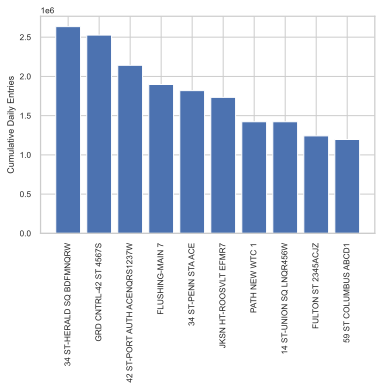

In [36]:
x = station_sum_entries['station_id'][:10]
y = station_sum_entries['ENTRIES'][:10]
plt.bar(x,y) 
plt.xticks(rotation=90);
plt.ylabel("Cumulative Daily Entries");

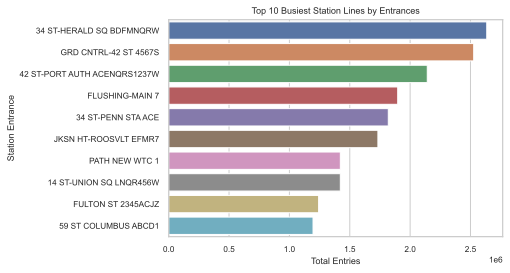

In [37]:
plt.figure()
sns.barplot(x=y, y=x,data=station_sum_entries, orient='h').set(title='Top 10 Busiest Station Lines by Entrances', ylabel='Station Entrance', xlabel='Total Entries');

plt.savefig('ten_busiest_stations.png', bbox_inches='tight', dpi=200)

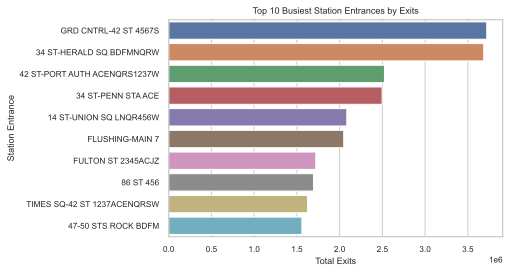

In [38]:
x = station_sum_exits['station_id'][:10]
y = station_sum_exits['total_exits'][:10]

plt.figure()
sns.barplot(x=y, y=x,data=station_sum_exits, orient='h').set(title='Top 10 Busiest Station Entrances by Exits', ylabel='Station Entrance', xlabel='Total Exits');

plt.savefig('ten_busiest_stations_exits.png', bbox_inches='tight', dpi=200)

# Station Entries by Day of the Week 

In [39]:
station_sum_entries[:10]

,station_id,ENTRIES
89,34 ST-HERALD SQ BDFMNQRW,2634766
312,GRD CNTRL-42 ST 4567S,2526630
102,42 ST-PORT AUTH ACENQRS1237W,2141962
289,FLUSHING-MAIN 7,1897147
93,34 ST-PENN STA ACE,1819080
339,JKSN HT-ROOSVLT EFMR7,1733084
404,PATH NEW WTC 1,1421847
28,14 ST-UNION SQ LNQR456W,1421764
302,FULTON ST 2345ACJZ,1241989
123,59 ST COLUMBUS ABCD1,1195711


In [40]:
def get_day_of_week(df_name, station_id):
    df_name = total_daily_entries[total_daily_entries['station_id'] == station_id].copy()
    df_name['DAY_OF_WEEK'] = pd.to_datetime(df_name.DATE).dt.dayofweek
    df_name['WEEK_NUMBER'] = pd.to_datetime(df_name.DATE).dt.isocalendar().week
    return df_name

In [41]:
st34_herald = get_day_of_week('st34_herald', '34 ST-HERALD SQ BDFMNQRW')
type(st34_herald)

pandas.core.frame.DataFrame

In [42]:
grd_cntrl = get_day_of_week('grd_cntrl', "GRD CNTRL-42 ST 4567S")
st42_port_auth = get_day_of_week('st42_port_auth', "42 ST-PORT AUTH ACENQRS1237W")
flushing_main = get_day_of_week('flushing_main', 'FLUSHING-MAIN 7')

In [43]:
st34_penn_sta = get_day_of_week('st34_penn_sta', '34 ST-PENN STA ACE')
jksn_ht_roosevelt = get_day_of_week('jksn_ht_roosevelt', 'JKSN HT-ROOSVLT EFMR7')
path_new_wtc = get_day_of_week('path_new_wtc', 'PATH NEW WTC 1')
st14_union_sq = get_day_of_week('st14_union_sq', '14 ST-UNION SQ LNQR456W')
fulton_st = get_day_of_week('fulton_st', 'FULTON ST 2345ACJZ')
st59_columbus = get_day_of_week('st59_columbus', '59 ST COLUMBUS ABCD1')
type(st59_columbus)

pandas.core.frame.DataFrame

In [44]:
station_weekdays_tup = [st34_herald, grd_cntrl, st42_port_auth, flushing_main, st34_penn_sta, jksn_ht_roosevelt, path_new_wtc, st14_union_sq, fulton_st, st59_columbus]
station_weekdays = pd.concat(station_weekdays_tup)
type(station_weekdays)


pandas.core.frame.DataFrame

In [45]:
station_by_weekday = station_weekdays.groupby(["station_id", "DAY_OF_WEEK"]).ENTRIES.sum().reset_index().sort_values(by=['station_id','DAY_OF_WEEK'])
station_weekdays

,C/A,UNIT,SCP,station_id,DATE,ENTRIES,DAY_OF_WEEK,WEEK_NUMBER
7189,A022,R022,01-00-00,34 ST-HERALD SQ BDFMNQRW,05/29/2021,824,5,21
7190,A022,R022,01-00-00,34 ST-HERALD SQ BDFMNQRW,05/30/2021,638,6,21
7191,A022,R022,01-00-00,34 ST-HERALD SQ BDFMNQRW,05/31/2021,761,0,22
7192,A022,R022,01-00-00,34 ST-HERALD SQ BDFMNQRW,06/01/2021,1321,1,22
7193,A022,R022,01-00-00,34 ST-HERALD SQ BDFMNQRW,06/02/2021,1345,2,22
...,...,...,...,...,...,...,...,...
114054,N051,R084,02-05-01,59 ST COLUMBUS ABCD1,08/23/2021,0,0,34
114055,N051,R084,02-05-01,59 ST COLUMBUS ABCD1,08/24/2021,0,1,34
114056,N051,R084,02-05-01,59 ST COLUMBUS ABCD1,08/25/2021,0,2,34
114057,N051,R084,02-05-01,59 ST COLUMBUS ABCD1,08/26/2021,0,3,34


In [46]:
station_by_weekday = station_by_weekday.set_index("station_id")

In [47]:
type(station_by_weekday)

pandas.core.frame.DataFrame

In [48]:
station_by_weekday.shape

(70, 2)

In [52]:
station_by_weekday = station_by_weekday.reset_index()

In [53]:
station_by_weekday = station_by_weekday.pivot("DAY_OF_WEEK", "station_id", 'ENTRIES')

<AxesSubplot:xlabel='station_id', ylabel='DAY_OF_WEEK'>

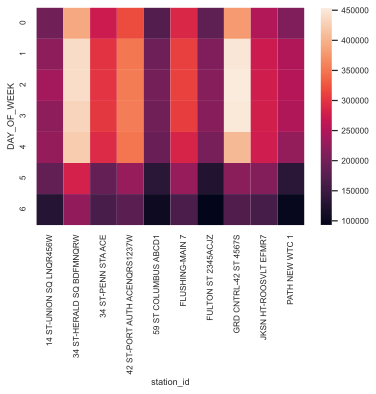

In [56]:
plt.figure()
sns.heatmap(data=station_by_weekday)

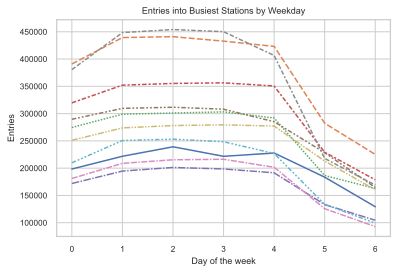

In [80]:
weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri']
plt.figure()
sns.lineplot(data=station_by_weekday, legend=False).set(title="Entries into Busiest Stations by Weekday", ylabel='Entries', xlabel='Day of the week')

plt.savefig('stations_by_weekday.png', dpi=200)
